## Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models, transforms
import torchvision

import imageio as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from modules_v6 import ContextUnet
from P1_CustomDataset import P1_CustomDataset
from P1_CombinedDataset import P1_CombinedDataset

packages during training

## Hyperparameters

In [2]:
BATCH_SIZE = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Define Custom Dataset

training dataset的mean & std

In [3]:
train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]

建train transform和val transform

val transform和test transform一樣

In [4]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

用P1_CustomDataset分別產生兩個資料集的train dataset，再將兩個dataset合成一個dataset，並產生trainloader

In [5]:
train_dataset_MNISTM = P1_CustomDataset(csv_file='../hw2_data/digits/mnistm/train.csv', root_dir='../hw2_data/digits/mnistm/data', transform=transform_train)
train_dataset_SVHN = P1_CustomDataset(csv_file='../hw2_data/digits/svhn/train.csv', root_dir='../hw2_data/digits/svhn/data', transform=transform_train)
combined_dataset = P1_CombinedDataset(train_dataset_MNISTM, train_dataset_SVHN)

combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print(len(combined_loader))

678


In [6]:
# print shape
image_first_batch, label_first_batch = next(iter(combined_loader))  #get first batch's image & mask 
label_dataset, label_image = label_first_batch
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_dataset.shape: ", label_dataset.shape)
print("label_image.shape: ", label_image.shape)
# get some values
print("normalized pixel value:", image_first_batch[3][0][9][8])
print("label_dataset (should be integer 0 ~ 1):",label_dataset[3])
print("label_image (should be integer 0 ~ 9):",label_image[3])

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([200, 3, 28, 28])
type(label_first_batch):  <class 'list'>
label_dataset.shape:  torch.Size([200])
label_image.shape:  torch.Size([200])
normalized pixel value: tensor(0.8275)
label_dataset (should be integer 0 ~ 1): tensor(1)
label_image (should be integer 0 ~ 9): tensor(1)


In [7]:
print("dataset label of first batch:", label_dataset) # two datasets are mixed together

dataset label of first batch: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label of dataset: tensor(0)
label of image: tensor(0)
shape:  (28, 28, 3)


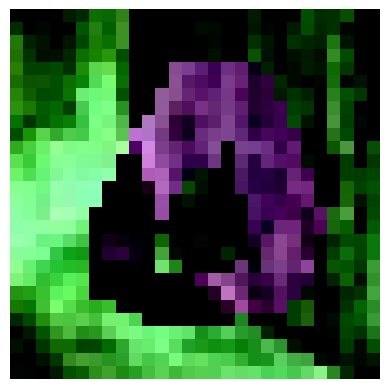

In [8]:
# visualize with normalization
idx = 0
first_image = image_first_batch[idx]
first_label_dataset = label_dataset[idx]
first_label_image = label_image[idx]
print("label of dataset:",first_label_dataset)
print("label of image:",first_label_image)

# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

print("shape: ",image_np.shape) # need to convert back to 28*28 during inference (in digit_classifier.py)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Build Model

instance model and put it on device

In [9]:
net = ContextUnet(in_channels=3, height=28, width=28, n_feat=128, n_cfeat=20, n_downs=2).to(device)

In [10]:
#print output shape
x = torch.randn(16,3,28,28).to(device) # dummy input也放到device
y = torch.randint(0, 20, (16,)).to('cuda')
y = F.one_hot(y, num_classes=20).float()
t_tensor = torch.full((16,), 9, device='cuda').float().unsqueeze(-1)
#dataset_label = torch.randint(0, 2, (10,)).to(device)
output = net(x, t_tensor, y)
print(output.shape)
print(y.shape)
print(t_tensor.shape)


torch.Size([16, 3, 28, 28])
torch.Size([16, 20])
torch.Size([16, 1])


## Training

Loss and Optimizer and epoch_n

In [11]:
# number of epoch
num_epochs = 50
# DDPM paper suggest using MSE as noise loss
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Different base learning rate and update strategy #!!!!!!
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(combined_loader), eta_min = 0) # update lr each batch

# total time steps
T = 350


#### DDPM training functions

alpha_t and alpha_hat_t of DDPM

In [12]:
# 1. beta
def beta_scheduler(n_timestep=1000, linear_start=1e-4, linear_end=2e-2):
    betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    return betas
beta_1 = 1e-4
beta_T = 2e-2
beta = beta_scheduler(T, beta_1, beta_T) 
# 2. alpha
alpha = 1 - beta
# 3. alpha_hat
# alpha hat = [alpha[0], alpha[0]*alpha[1], alpha[0]*alpha[1]*alpha[2], ... ,alpha[0]*...*alpha[T-1])] 
alpha_hat = torch.zeros_like(alpha) # tensor with len T, alpha_hat.shape = T
alpha_hat[0] = alpha[0] # Set the first element
for i in range(1, alpha.shape[0]):
    alpha_hat[i] = alpha_hat[i - 1] * alpha[i]


torch.save(beta, './alpha_tensors/beta_tensor.pt')
torch.save(alpha, './alpha_tensors/alpha_tensor.pt')
torch.save(alpha_hat, './alpha_tensors/alpha_hat_tensor.pt')

functions

In [13]:
def noise_x_t(alpha_hat, x_0, t, epsilon):
    """given x[0](origin image) and t, return x[t](noisy image from x[0] by adding epsilon repeatly t times)"""
    """一步登天"""
    """epsilon.shape = x_0.shape = N*C*H*W,  t.shape = N"""
    """alpha_hat.shape = T, index t = 0 ~ T-1"""

    sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_alpha_hat.shape = N*1*1*1
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_one_minus_alpha_hat.shape = N*1*1*1

    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * epsilon
    
    return x_t #x[t] is N*C*H*W

In [14]:
# given (N, 20) context, return masked context with same shape
# ex: original class = 0 ==> one-hot = [1, 0, 0...] ==> if randomly zero out(q = 0.1), return [0, 0, ...]
def get_masked_context(context, p=0.9):
    mask = torch.bernoulli(torch.ones_like(context) * p)
    return context * mask

#### training loop (DDPM framework)

In [15]:
# Training Loop
model_version = 6   # version 6: combined 2 datasets to 1 dataset + change model
training_version = 1 # for name of checkpoint model # train的第幾次

train_loss_list = []
save_model_loss_list = []
lr_list = []

beta = beta.to(device)
alpha = alpha.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, label_dataset_image in tqdm(combined_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        # ========================================================== step1: x0 ~ q(x0) ===========================================================
        # x0 is original image: images
        dataset_label = label_dataset_image[0]
        image_label = label_dataset_image[1]
        images, dataset_label, image_label = images.to(device), dataset_label.to(device), image_label.to(device)# model, input output of model are moved to GPU during training
        N, C, H, W = images.shape[0], images.shape[1], images.shape[2], images.shape[3]
        # ========================================================== step1-1: preprocess of label ===========================================================
        # version6: combine two datasets into one
        image_label = image_label + 10 * dataset_label 
        image_label = F.one_hot(image_label, num_classes=20)  # Encode class labels as one-hot vectors, shape = (N, 20)
        # Apply masking to the context (class labels)
        masked_image_label = get_masked_context(image_label).to(device) # shape = (N, 20) # randomly zero out one-hot vector: [0,0,1,0,..] -> [0,0,0,0,..]

        # ==================================================== step2: t ~ Uniform({1,...,T}) =====================================================
        t_np = np.random.randint(0, T, size=(N,))  # Sample t from Uniform({0, ..., T-1}) # python is 0-indexing
        t = torch.from_numpy(t_np)
        t = t.to(device)

        # ======================================================= step3: epsilon ~ N(0, 1) =======================================================
        noise = torch.randn(N, C, H, W)  # Sample noise from normal distribution with mean 0 and standard deviation 1
        noise = noise.to(device)         # dtype = float32     # shape = N* C* H* W

        # ===================================== step4: take gradient descent step on noise and predict_noise =====================================
        x_t = noise_x_t(alpha_hat=alpha_hat, x_0=images, t=t, epsilon=noise)
        x_t = x_t.to(device)

        # 10% chance to zero-out # 10% of training is unconditional training
        predict_noise = net(x=x_t.float(), t=(t/T), c=masked_image_label.float()) #x=N*C*H*W, t=N, y=N*20 

        loss = criterion(noise, predict_noise) # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        scheduler.step() # update lr each batch(cosine scheduler)
        


    train_loss /= len(combined_loader)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}')
    print(f'Learning rate {scheduler.get_last_lr()[0]}')
    train_loss_list.append(train_loss)

    #scheduler.step() # update lr each epoch(linear step scheduler)
    lr_list.append(scheduler.get_last_lr()[0])

    if epoch % 10 == 0:
        # save the model state_dict
        save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth')
        torch.save(net.state_dict(), save_dir)
        save_model_loss_list.append([f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth' ,train_loss])
        print(f'Saved model to {save_dir}. Training loss = {train_loss}')

# save the model state_dict
save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}.pth')
torch.save(net.state_dict(), save_dir)
print(f'Saved model  to {save_dir}')

Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [05:59<00:00,  1.88batch/s]


Epoch 1/50 - Loss: 0.0912
Learning rate 9.990133642141363e-05
Saved model to ../checkpoint_model/P1/P1_model_ver6_1_epoch0.pth. Training loss = 0.09118068385264866


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 2/50 - Loss: 0.0536
Learning rate 9.960573506572393e-05


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 3/50 - Loss: 0.0471
Learning rate 9.911436253643464e-05


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 4/50 - Loss: 0.0445
Learning rate 9.842915805643152e-05


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 5/50 - Loss: 0.0424
Learning rate 9.755282581475782e-05


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 6/50 - Loss: 0.0409
Learning rate 9.648882429441255e-05


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 7/50 - Loss: 0.0399
Learning rate 9.524135262330088e-05


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 8/50 - Loss: 0.0388
Learning rate 9.381533400219307e-05


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 9/50 - Loss: 0.0383
Learning rate 9.221639627510047e-05


Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 10/50 - Loss: 0.0377
Learning rate 9.045084971874724e-05


Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 11/50 - Loss: 0.0373
Learning rate 8.852566213878943e-05
Saved model to ../checkpoint_model/P1/P1_model_ver6_1_epoch10.pth. Training loss = 0.03728151605752981


Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 12/50 - Loss: 0.0366
Learning rate 8.644843137107093e-05


Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 13/50 - Loss: 0.0368
Learning rate 8.422735529643484e-05


Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 14/50 - Loss: 0.0361
Learning rate 8.18711994874348e-05


Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 15/50 - Loss: 0.0361
Learning rate 7.938926261462396e-05


Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 16/50 - Loss: 0.0356
Learning rate 7.679133974895011e-05


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 17/50 - Loss: 0.0354
Learning rate 7.408768370508605e-05


Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 18/50 - Loss: 0.0350
Learning rate 7.128896457825382e-05


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 19/50 - Loss: 0.0350
Learning rate 6.840622763423391e-05


Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 20/50 - Loss: 0.0348
Learning rate 6.54508497187475e-05


Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:01<00:00,  1.88batch/s]


Epoch 21/50 - Loss: 0.0348
Learning rate 6.243449435824276e-05
Saved model to ../checkpoint_model/P1/P1_model_ver6_1_epoch20.pth. Training loss = 0.03482496674147855


Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 22/50 - Loss: 0.0347
Learning rate 5.9369065729286394e-05


Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 23/50 - Loss: 0.0339
Learning rate 5.62666616782154e-05


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 24/50 - Loss: 0.0340
Learning rate 5.313952597646575e-05


Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 25/50 - Loss: 0.0336
Learning rate 5.000000000000017e-05


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 26/50 - Loss: 0.0337
Learning rate 4.686047402353449e-05


Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 27/50 - Loss: 0.0337
Learning rate 4.373333832178499e-05


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 28/50 - Loss: 0.0332
Learning rate 4.063093427071397e-05


Epoch 29/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 29/50 - Loss: 0.0331
Learning rate 3.756550564175743e-05


Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 30/50 - Loss: 0.0330
Learning rate 3.4549150281252765e-05


Epoch 31/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 31/50 - Loss: 0.0330
Learning rate 3.159377236576619e-05
Saved model to ../checkpoint_model/P1/P1_model_ver6_1_epoch30.pth. Training loss = 0.03302166437603819


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 32/50 - Loss: 0.0327
Learning rate 2.871103542174646e-05


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 33/50 - Loss: 0.0328
Learning rate 2.591231629491434e-05


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 34/50 - Loss: 0.0324
Learning rate 2.3208660251050226e-05


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 35/50 - Loss: 0.0326
Learning rate 2.0610737385376444e-05


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 36/50 - Loss: 0.0323
Learning rate 1.8128800512565618e-05


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 37/50 - Loss: 0.0323
Learning rate 1.577264470356568e-05


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 38/50 - Loss: 0.0321
Learning rate 1.355156862892954e-05


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 39/50 - Loss: 0.0321
Learning rate 1.1474337861210647e-05


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 40/50 - Loss: 0.0318
Learning rate 9.549150281252725e-06


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [06:00<00:00,  1.88batch/s]


Epoch 41/50 - Loss: 0.0321
Learning rate 7.783603724899329e-06
Saved model to ../checkpoint_model/P1/P1_model_ver6_1_epoch40.pth. Training loss = 0.03208900752386688


Epoch 42/50:  99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 673/678 [05:58<00:02,  1.87batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



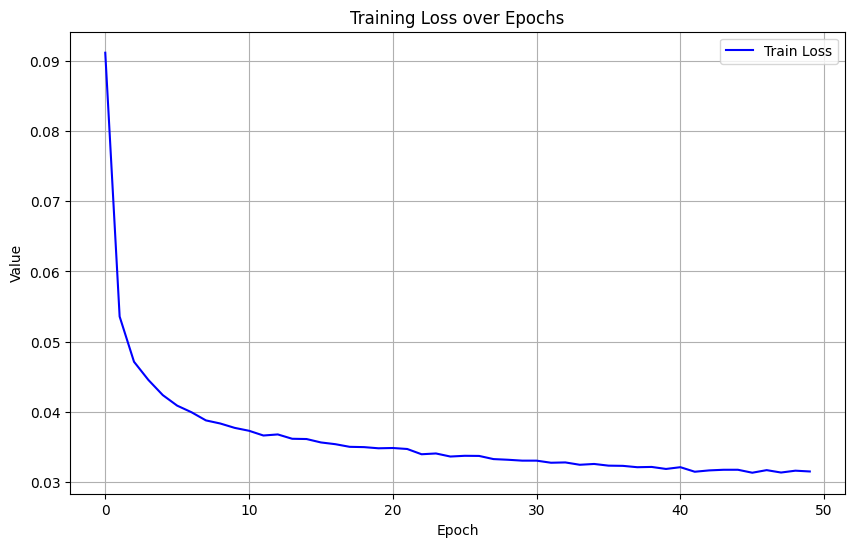

In [16]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')

# Adding titles and labels
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
# Show the plot
plt.show()

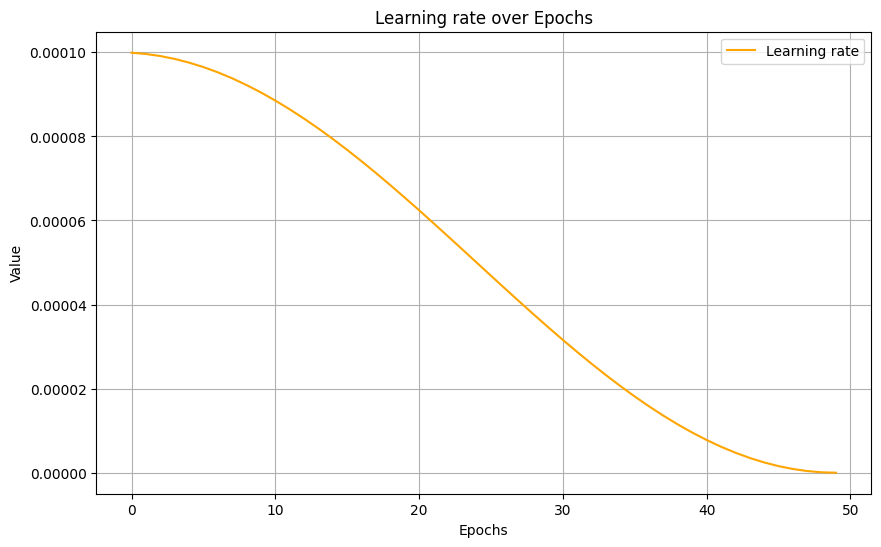

In [17]:
plt.figure(figsize=(10, 6))
# Plot Learning rate
plt.plot(lr_list, label='Learning rate', color='orange')


# Adding titles and labels
plt.title('Learning rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [18]:
print(train_loss_list)

[0.09118068385264866, 0.05356635698350833, 0.04712098757777594, 0.04452698997285074, 0.04236917626277535, 0.04086666200639664, 0.03992168252304153, 0.03876124724064429, 0.03831754474568244, 0.03769571946763535, 0.03728151605752981, 0.036606276171573145, 0.03675947653728601, 0.03614175284231922, 0.036103831117857345, 0.03561685160956288, 0.035369526512459316, 0.03499274640714964, 0.03495026263889134, 0.0347845519681332, 0.03482496674147855, 0.03468475601797962, 0.033934316556669966, 0.03404572006908402, 0.03360885048730183, 0.03371431734303018, 0.03369460617546487, 0.03324484307549696, 0.03314998243443646, 0.03302311845903991, 0.03302166437603819, 0.03272420654188743, 0.032768182753197914, 0.03243402329309236, 0.03255018690232858, 0.03230995821401169, 0.0322800570862659, 0.032086167984523954, 0.03212604209901573, 0.031838372319519165, 0.03208900752386688, 0.0314406462310426, 0.03163188215685805, 0.031721567122436026, 0.0317233810063924, 0.03130080961625045, 0.031669166112170286, 0.03132

In [19]:
for name, loss in save_model_loss_list:
    print(f"{name}:  {loss}")

P1_model_ver6_1_epoch0.pth:  0.09118068385264866
P1_model_ver6_1_epoch10.pth:  0.03728151605752981
P1_model_ver6_1_epoch20.pth:  0.03482496674147855
P1_model_ver6_1_epoch30.pth:  0.03302166437603819
P1_model_ver6_1_epoch40.pth:  0.03208900752386688


In [20]:
print(lr_list)

[9.990133642141363e-05, 9.960573506572393e-05, 9.911436253643464e-05, 9.842915805643152e-05, 9.755282581475782e-05, 9.648882429441255e-05, 9.524135262330088e-05, 9.381533400219307e-05, 9.221639627510047e-05, 9.045084971874724e-05, 8.852566213878943e-05, 8.644843137107093e-05, 8.422735529643484e-05, 8.18711994874348e-05, 7.938926261462396e-05, 7.679133974895011e-05, 7.408768370508605e-05, 7.128896457825382e-05, 6.840622763423391e-05, 6.54508497187475e-05, 6.243449435824276e-05, 5.9369065729286394e-05, 5.62666616782154e-05, 5.313952597646575e-05, 5.000000000000017e-05, 4.686047402353449e-05, 4.373333832178499e-05, 4.063093427071397e-05, 3.756550564175743e-05, 3.4549150281252765e-05, 3.159377236576619e-05, 2.871103542174646e-05, 2.591231629491434e-05, 2.3208660251050226e-05, 2.0610737385376444e-05, 1.8128800512565618e-05, 1.577264470356568e-05, 1.355156862892954e-05, 1.1474337861210647e-05, 9.549150281252725e-06, 7.783603724899329e-06, 6.184665997806887e-06, 4.758647376699063e-06, 3.51117